In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import os
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import glob as gb
import cv2
from tensorflow import keras

from keras import backend as K
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Dropout, Input, Add, Dense, Activation, ZeroPadding2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

# Model
from tensorflow.keras.optimizers import Adam

# Model Checks
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import itertools


import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

#Model Graphs
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
# Set the style to whitegrid
plt.style.use('seaborn-whitegrid')
plt.style.library['seaborn-whitegrid']
plt.style.use("seaborn-v0_8-whitegrid")

from matplotlib import rcParams
rcParams['font.weight'] = 'bold'

2024-04-07 11:14:11.959007: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 11:14:11.959113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 11:14:12.084663: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Prepare Dataset**

In [2]:
labels=["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]

In [3]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/kaggle/input/brain-tumor-neutrosophic-dataset/Brain Tumor Neutrosophic Dataset/T','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

100%|██████████| 827/827 [00:08<00:00, 97.34it/s]


In [4]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [5]:
from sklearn.model_selection import train_test_split

X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [6]:
X_test = []
y_test = []

for i in labels:
    folderPath = os.path.join('/kaggle/input/brain-tumor-neutrosophic-dataset/Brain Tumor Neutrosophic Dataset/T','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)

100%|██████████| 74/74 [00:00<00:00, 91.75it/s]


In [7]:
X_test = np.array(X_test)
y_test = np.array(y_test)

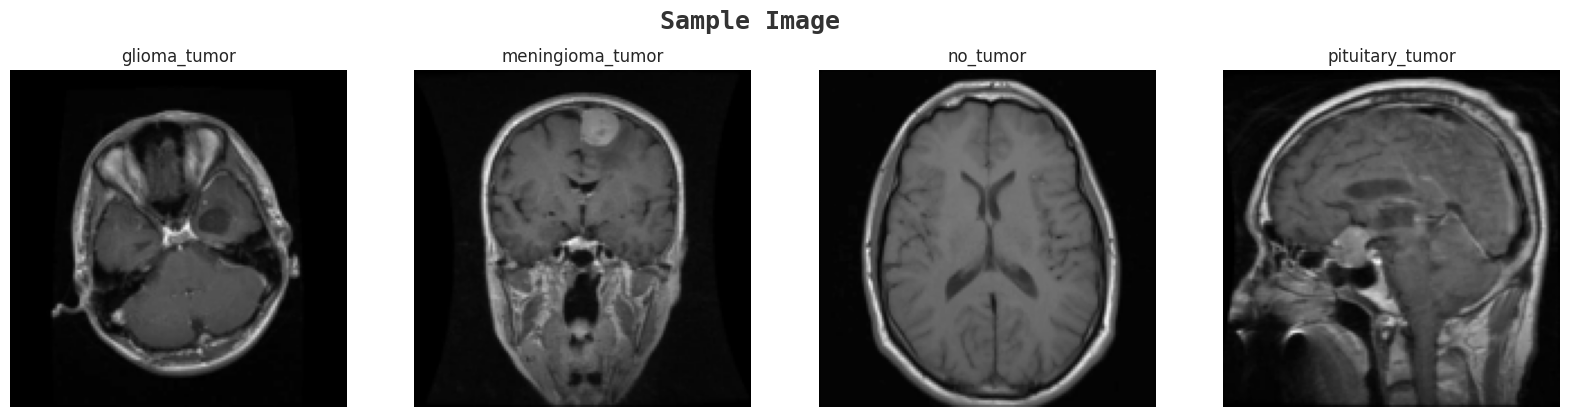

In [8]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image ',size=18,fontweight='bold',
             fontname='monospace',color='black',y=0.60,x=0.45,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Fit label encoder and transform labels
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

In [10]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
y_val = tf.keras.utils.to_categorical(y_val)

# **ResNet50**

In [11]:
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add custom top layers 
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(4, activation='softmax')(x)  

model = Model(inputs=base_model.input, outputs=predictions)

#freeze layers of the model
for layer in base_model.layers:
    layer.trainable = False



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 25,689,988 (98.00 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=30, verbose=1 , callbacks=[early_stopping])

Epoch 1/30
 5/81 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.2625 - loss: 3.2947

I0000 00:00:1712488512.069771      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6242 - loss: 1.6058

W0000 00:00:1712488518.610273      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 183ms/step - accuracy: 0.6258 - loss: 1.5966 - val_accuracy: 0.8467 - val_loss: 0.4200
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.8430 - loss: 0.3927 - val_accuracy: 0.8746 - val_loss: 0.3526
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9122 - loss: 0.2474 - val_accuracy: 0.8955 - val_loss: 0.2599
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9376 - loss: 0.1613 - val_accuracy: 0.8815 - val_loss: 0.3155
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9464 - loss: 0.1647 - val_accuracy: 0.8780 - val_loss: 0.3348
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9676 - loss: 0.0930 - val_accuracy: 0.8850 - val_loss: 0.3282
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9737 - loss: 0.0789 - val_accuracy: 0.9164 - val_loss: 0.2570
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9785 - loss: 0.0612 - val_accuracy: 0.9268 - val_loss:

# **Model Predictions**

In [15]:
from tensorflow.keras.utils import to_categorical
y_pred = model.predict(X_test)
y_pred2= to_categorical(np.argmax(y_pred, axis=1), 4)

# Using it in AUC
y_pred1=(np.argmax(y_pred, axis=1))
y_test1=(np.argmax(y_test, axis=1))

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 438ms/step


# **Model Evaluations**

In [16]:
def evaluate_model(X_test , y_test):
    results = model.evaluate(X_test , y_test)
    return results
def Accuracy(y_test , y_pred):
    AccScore = accuracy_score(y_test, y_pred, normalize=True)
    return AccScore
def macro_precision(y_test , y_pred):
    PrecisionScore = precision_score(y_test, y_pred, average='macro') 
    return PrecisionScore
def macro_recall(y_test , y_pred):
    RecallScore = recall_score(y_test, y_pred, average='macro') 
    return  RecallScore
def macro_F1Score(y_test , y_pred):
    F1Score = f1_score(y_test, y_pred, average='macro') 
    return F1Score

In [17]:
from sklearn.metrics import roc_auc_score

# Calculating Area under the curve
def AUC(actual_class, pred_class, average="micro"):
    # Making a set of all the unique classes
    unique_class = set(actual_class)
    roc_auc_dict = {}
    total_auc = 0  # Variable to store the total AUC score

    for per_class in unique_class:
        # Making a list of all the classes except the current class
        other_class = [x for x in unique_class if x != per_class]

        # Making the current class with label 1 and all other classes as a label 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        # Calculating the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average=average)
        roc_auc_dict[per_class] = roc_auc
        total_auc += roc_auc

    # Calculating the average AUC score for all classes
    average_auc = total_auc / len(unique_class)

    return roc_auc_dict, average_auc

In [18]:
print("***** Model Evaluations Details ******** \n")
print("Test loss, Test acc : " , evaluate_model(X_test,y_test)) 
print("******************************")
print("Accuracy  : " , Accuracy(y_test1 , y_pred1)) 
print("******************************")
print("Precision Score is : " , macro_precision(y_test1 , y_pred1))
print("******************************")
print("Recall Scores is : " , macro_recall(y_test1 , y_pred1))
print("******************************")
print('F1 Score is : ', macro_F1Score(y_test1 , y_pred1))
print("******************************")
roc_auc_dict, average_auc = AUC(y_test1, y_pred1)
print('AUC Score for each class  : ' , roc_auc_dict)
print('AUC Average Score   : ' , average_auc)

***** Model Evaluations Details ******** 

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.5704 - loss: 3.8920
Test loss, Test acc :  [1.9965449571609497, 0.7461928725242615]
******************************
Accuracy  :  0.7461928934010152
******************************
Precision Score is :  0.8370523616409699
******************************
Recall Scores is :  0.7370240893066979
******************************
F1 Score is :  0.7117557239508459
******************************
AUC Score for each class  :  {0: 0.615, 1: 0.8628019323671496, 2: 0.9377162629757785, 3: 0.8820101351351352}
AUC Average Score   :  0.8243820826195158


In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test1, y_pred1, target_names=labels))

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.23      0.37       100
meningioma_tumor       0.64      0.95      0.76       115
        no_tumor       0.74      1.00      0.85       105
 pituitary_tumor       0.97      0.77      0.86        74

        accuracy                           0.75       394
       macro avg       0.84      0.74      0.71       394
    weighted avg       0.82      0.75      0.71       394



# **Graphical Results**

In [20]:
def plot_roc_curve(y_test,y_pred):
    n_classes=4
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw=2
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
    plt.figure(figsize=(8, 8))
    plt.plot(fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,)

    plt.plot(fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

    colors = cycle(["aqua", "darkorange", "cornflowerblue",'#9e9e9e'
                   ])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(
           fpr[i],
           tpr[i],
           color=color,
           lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(labels[i], roc_auc[i]),
    )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate" , weight='bold')
    plt.ylabel("True Positive Rate" , weight='bold')
    plt.title("T | ResNet50-Roc-Curve" , weight='bold')
    plt.legend(loc="lower right")

    plt.show()

In [21]:
def Acc_Loss_Graph(history):
    # converting hsitory to dataframe
    pd.DataFrame(history.history)

    pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
    plt.title('T | ResNet50 Accuracy' , weight='bold')
    plt.xlabel('Epochs' , weight='bold')
    plt.ylabel('Accuracy' , weight='bold')
    plt.legend()
    plt.show()

    pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
    plt.title('T | ResNet50 Loss' , weight='bold')
    plt.xlabel('Epochs' , weight='bold')
    plt.ylabel('loss' , weight='bold')
    plt.legend()
    plt.show()

In [22]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (5, 5))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title , weight='bold')
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 90)
	plt.yticks(tick_marks, classes)
	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')
	else:
		print('Confusion Matrix, Without Normalization')
	print(cm)
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
	plt.tight_layout()
	plt.ylabel('Actual Label' , weight='bold')
	plt.xlabel('Predicted Label' , weight='bold')

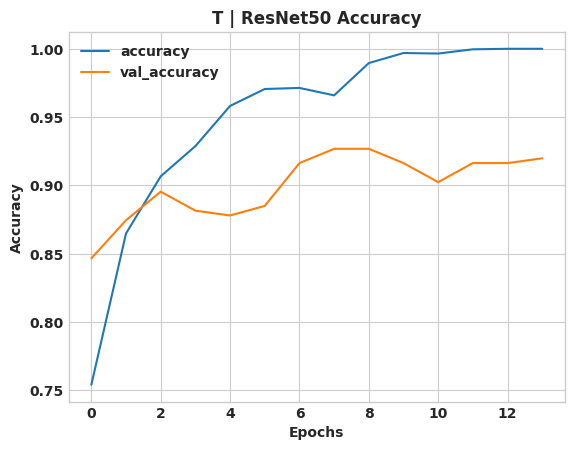

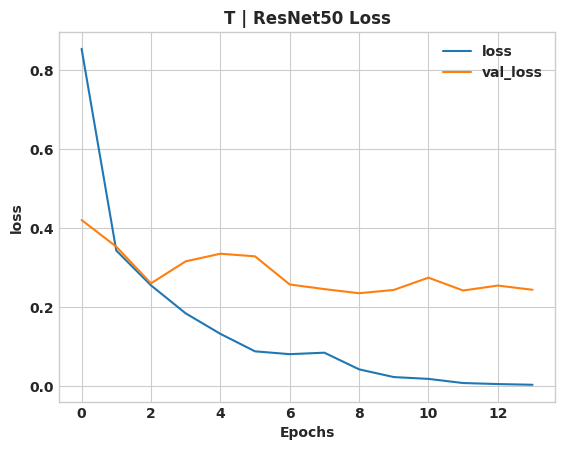

In [23]:
Acc_Loss_Graph(history)

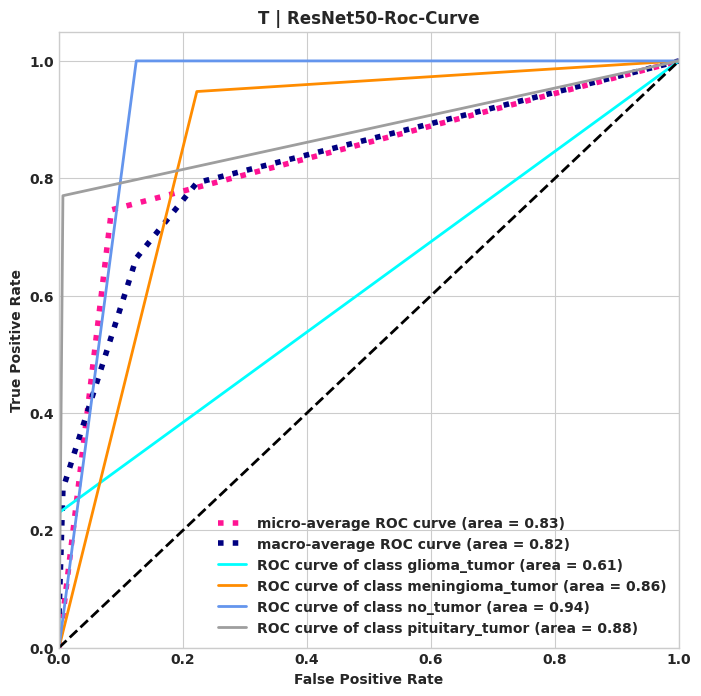

In [24]:
plot_roc_curve(y_test,y_pred2)

Confusion Matrix, Without Normalization
[[ 23  50  25   2]
 [  0 109   6   0]
 [  0   0 105   0]
 [  0  12   5  57]]


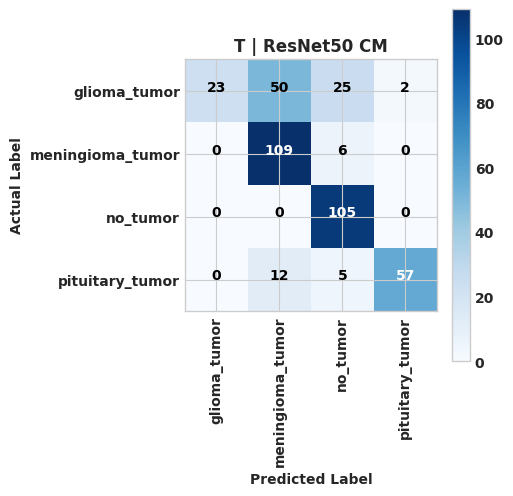

In [25]:
# Calculate confusion matrix
cm = confusion_matrix(y_test1, y_pred1)

# Plot confusion matrix
plot_confusion_matrix(cm=cm, classes=labels, title='T | ResNet50 CM')